# **Imports**

In [ ]:
%%capture
!pip install -q lime shap

In [ ]:
# Import model-specific libraries (e.g., sklearn, XGBoost, SHAP)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import kagglehub
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, learning_curve, ValidationCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc,PrecisionRecallDisplay
from sklearn.inspection import PartialDependenceDisplay,permutation_importance
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
import textwrap
from imblearn.pipeline import Pipeline as ImbPipeline
import lime
import lime.lime_tabular
import shap
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc, roc_curve
import warnings
warnings.filterwarnings('ignore')

# **Utils**

In [ ]:
def our_confusion_matrix(model, name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap="Oranges", ax=ax1)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Oranges", ax=ax2)
    plt.title(f"{name} Confusion Matrix")

def our_roc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    roc1 = RocCurveDisplay.from_estimator(
    model, X_train, y_train,
    name=name, ax=ax1,
    color="orange"
    )
    roc2 = RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        name=name, ax=ax2,
        color="orange"
    )
    ax1.fill_between(roc1.fpr, roc1.tpr, alpha=0.4, color="orange")
    ax2.fill_between(roc2.fpr, roc2.tpr, alpha=0.4, color="orange")
    ax1.set_title(f"{name} Training ROC Curve", fontsize=16)
    ax2.set_title(f"{name} Testing ROC Curve", fontsize=16)
    for ax in [ax1, ax2]:
        ax.grid(alpha=0.5)

def our_learning_curve(model, name='Model'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )

    plt.figure(figsize=(13, 8))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="mediumseagreen", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="royalblue", label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)

def our_prc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 13))
    train_disp = PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=ax1, color='orange')
    test_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, color='orange')
    ax1.set_title(f"{name} Precision-Recall Curve - Train")
    ax2.set_title(f"{name} Precision-Recall Curve - Test")
    ax1.fill_between(train_disp.recall, train_disp.precision, alpha=0.4, color='orange')
    ax2.fill_between(test_disp.recall, test_disp.precision, alpha=0.4, color='orange')

# **Load Processed Dat**a

In [ ]:
path = kagglehub.dataset_download('mohamedhassan77/xai-project-processed-data')
df = pd.read_csv(f"{path}/combined_adasyn_train_test.csv")
df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,promotion_velocity,workload_score,compensation_ratio,Attrition,Set
0,31,2,1062,1,24,3,3,3,0,96,...,3,10.0,9,1,8,9.999900,1,1.019760,0,Train
1,50,2,328,1,1,3,3,3,1,86,...,2,3.0,2,0,2,300000.000000,2,1.281918,0,Train
2,46,2,717,1,13,4,1,3,1,34,...,3,10.0,7,0,9,1000000.000000,1,0.832635,0,Train
3,44,2,170,1,1,4,1,2,1,78,...,3,2.0,0,2,2,0.999995,1,0.753443,0,Train
4,26,1,1479,1,1,3,1,3,0,84,...,1,6.0,5,1,4,5.999940,3,1.007878,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,56,2,1162,1,24,2,1,1,1,97,...,3,4.0,2,1,0,3.999960,1,0.898732,1,Test
2043,46,2,669,2,9,2,3,3,1,64,...,3,9.0,8,4,7,2.249994,1,1.558490,1,Test
2044,30,2,1240,0,9,3,0,3,1,48,...,1,11.0,9,4,7,2.749993,7,2.052053,0,Test
2045,31,2,741,1,2,4,1,2,1,69,...,4,5.0,2,0,3,500000.000000,0,1.207921,0,Test


In [ ]:
train_df = df[df['Set'] == 'Train'].drop(columns=['Set'])
test_df = df[df['Set'] == 'Test'].drop(columns=['Set'])

X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']

X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (1589, 33) y_train: (1589,)
X_test: (458, 33) y_test: (458,)


# **Model-Specific EDA (Optional)**

Target variable distribution in the training set:
Attrition
1    804
0    785
Name: count, dtype: int64


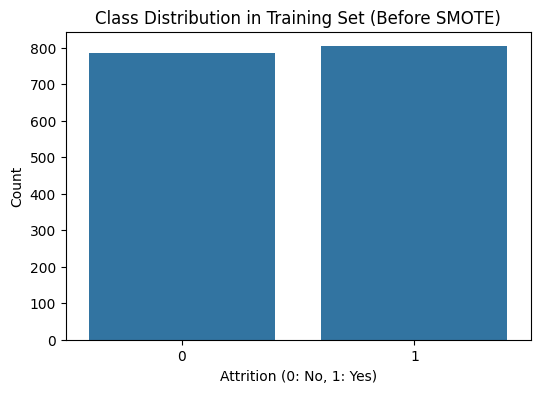

In [ ]:
print("Target variable distribution in the training set:")
print(y_train.value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Class Distribution in Training Set (Before SMOTE)')
plt.xlabel('Attrition (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# **Model Initialization**

In [ ]:
nb_classifier = GaussianNB()

# **Model Training**

In [ ]:
nb_classifier.fit(X_train, y_train)

GaussianNB()

# **Model Evaluation**

In [ ]:
y_pred = nb_classifier.predict(X_test)
y_pred_proba = nb_classifier.predict_proba(X_test)[:, 1]

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4192


In [ ]:
print("Classification Report:")
report = classification_report(y_test, y_pred, target_names=['No Attrition', 'Attrition'])
print(report)

Classification Report:
              precision    recall  f1-score   support

No Attrition       0.85      0.35      0.50       373
   Attrition       0.20      0.72      0.31        85

    accuracy                           0.42       458
   macro avg       0.52      0.53      0.41       458
weighted avg       0.73      0.42      0.46       458





> The model performed poorly for both classes, with a low recall (0.35) for "No Attrition", which means that the model misses 65% of acutal attrition cases.



> The overall accuracy was 42%. Even Random guessing is better than this model. In other words, if swapped the prediction we would get a better model with accuracy equal to 58%.



> The model is highly unreliable for this case.







In [ ]:
our_confusion_matrix(nb_classifier, name='Naive Bayes')
plt.savefig('Confusion Matrix - NB.jpg')
plt.close()

In [ ]:
our_roc(nb_classifier, name="Naive Bayes")
plt.savefig('ROC Train&Test- NB.jpg')
plt.close()



> The model perform a little be well in distinguishing the positive class in training.


>  In testing it is nearly random (0.53)





In [ ]:
our_learning_curve(nb_classifier, name='Naive Bayes')
plt.savefig('Learning Curve - ETC.jpg')
plt.close()



> The model is underfitting with more data, as examples increaes the performance decreases.



> The model is too weak (simple) and can not capture the pattern.





In [ ]:
our_prc(nb_classifier, name="Naive Bayes")
plt.savefig('Percision&Recall Train&Test - NB.jpg')
plt.close()



> Initially, the training score is high but then it dropped down significantly



> The cross-validation score starts at low and, raises a little bit, then stabilize.



> The gap difference suggest that the model failed to generalize







# **Explainability Techniques**

## LIME Analysis

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No Attrition', 'Attrition'],
    mode='classification'
)

instance = X_test.iloc[0]

pred_prob = nb_classifier.predict_proba([instance])[0][1]

exp = explainer.explain_instance(instance.values, nb_classifier.predict_proba, num_features=10)

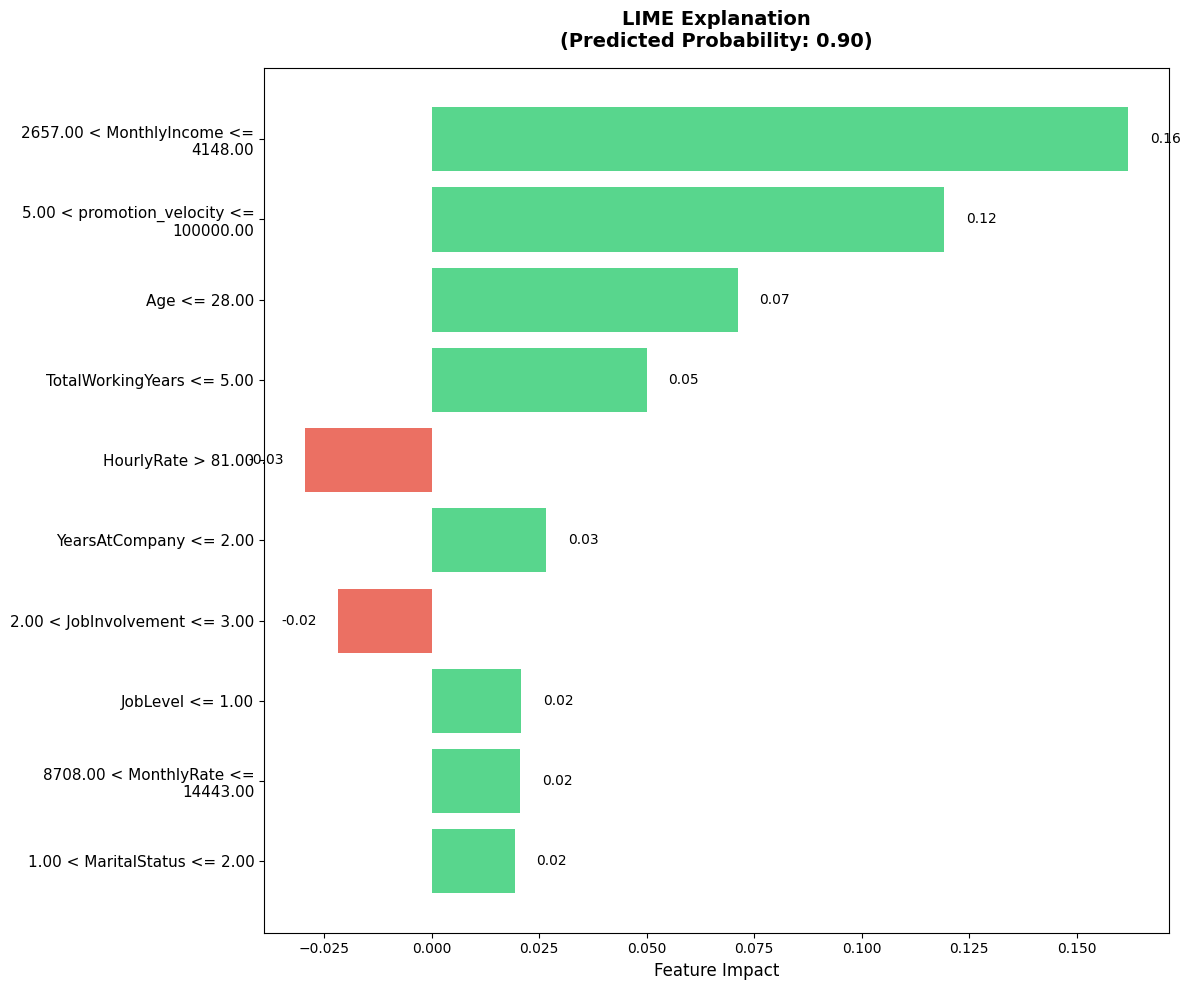

In [ ]:
pred_prob = nb_classifier.predict_proba(instance.values.reshape(1, -1))[0, 1]

values = [v for _, v in exp.as_list(label=1)]
features = [f for f, _ in exp.as_list(label=1)]
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in values]

wrapped_features = [textwrap.fill(f, width=30) for f in features]

fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(wrapped_features))
bars = ax.barh(y_pos, values, color=colors, alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(wrapped_features, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Feature Impact', fontsize=12)
ax.set_title(f'LIME Explanation\n(Predicted Probability: {pred_prob:.2f})', fontsize=14, weight='bold', pad=15)

for i, v in enumerate(values):
    ax.text(v + 0.005 if v > 0 else v - 0.005, i, f"{v:.2f}",
            va='center', ha='left' if v > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig('LIME - NB.jpg')
plt.close()

**The 90% is the Attrition risk.**

> Green bars are the features that increase the chance of leaving, While red bars decreases it.

> MonthlyIncome (≤4148.00) has the most impact for employee to leave. Promotion_velocity (≤10000.00) and Age (≤28.00) are also strong flags to push the employee toward leaving the compnay.

> HourlyRate (>81.00002) and JobInvolvment (≤3.00) decrease the probability of leaving. The same intepretation with the other columns.

## SHAP Analysis

  0%|          | 0/100 [00:00<?, ?it/s]

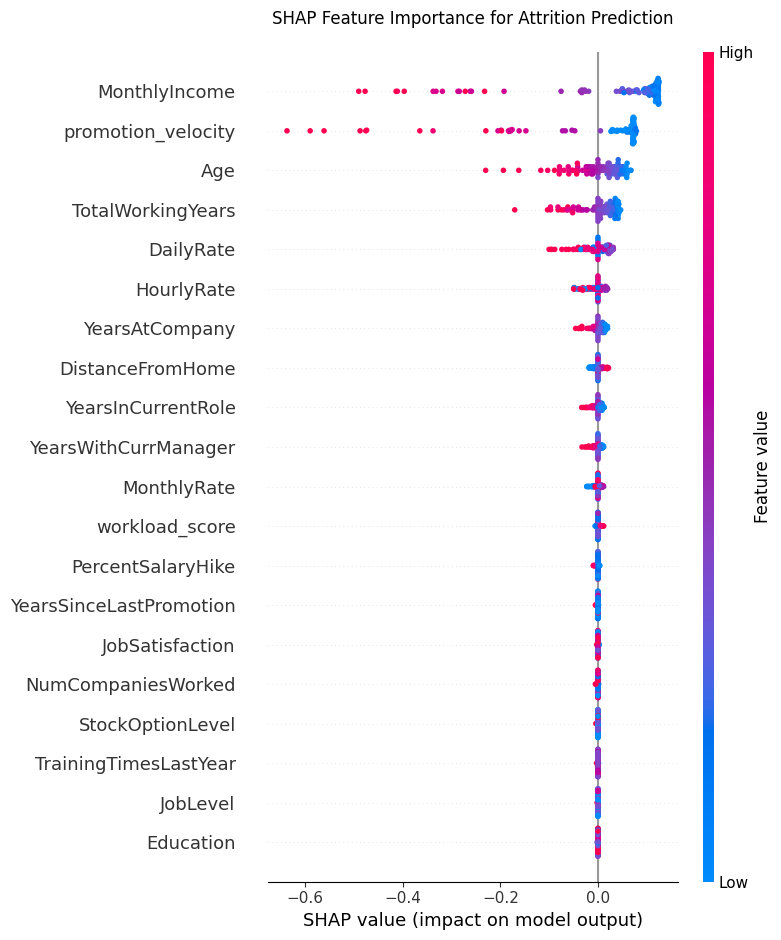

In [ ]:
explainer = shap.KernelExplainer(nb_classifier.predict_proba, shap.sample(X_train, 100))
sample_size = min(100, len(X_test))
X_sample = X_test.iloc[:sample_size]

shap_values = explainer.shap_values(X_sample)

if len(np.array(shap_values).) ==shape 3:
    shap_values_attrition = shap_values[:,:,1]
elif len(np.array(shap_values).shape) == 2:
    shap_values_attrition = shap_values

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_attrition,
    X_sample,
    feature_names=X_train.columns.tolist(),
    plot_type="dot",
    show=False
)
plt.title("SHAP Feature Importance for Attrition Prediction", pad=20)
plt.tight_layout()
plt.show()
plt.savefig('SHAP - NB.jpg')
plt.close()

> Each dot represent a person, and color show if their value for this feature is high (red) or low (blue).

> MonthlyIncome is the most infulential factor, people with low income (blue dots) are more likely to leave, while those with high income (red dots) are more likely to stay.

> On the other hand, Education and JobLevel have a smaller impact. The spread of dots is narrow, meaning that these features doesn't strongly push the prediction toward staying or leaving.



## Feature Importance (Model-Specific)

## Partial Dependence Plots

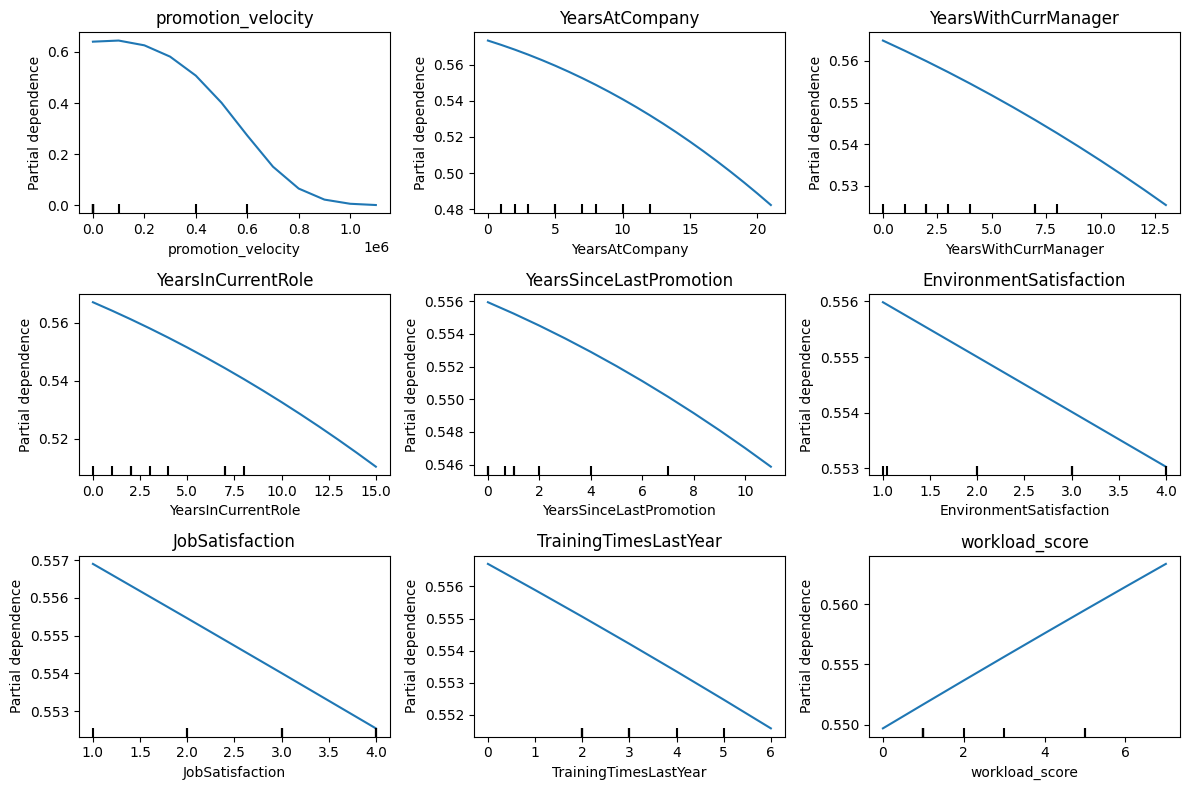

In [ ]:
perm = permutation_importance(nb_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
top9 = X_train.columns[perm.importances_mean.argsort()][-9:][::-1]

fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for ax, feature in zip(axes, top9):
    PartialDependenceDisplay.from_estimator(nb_classifier, X_test, [feature], ax=ax)
    ax.set_title(feature)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
plt.savefig('PDP - NB.jpg')
plt.close()

> The PDP graph shows how different features influnces the target variable. The strongest feature is the Pormotion_velocity which decreased significantly from 0.6 to zero, indicatingg that lower promotion velocity increases the likelihood of attrition.



>  On the other hand, the Workload_score PDP raises from ~0.550 to ~0.560 as the workload increases. This indicates that higher workload slightly increases the likelihood of attrition. The effect is very small, and doesn't impact too much.












## Permutation Feature Importance

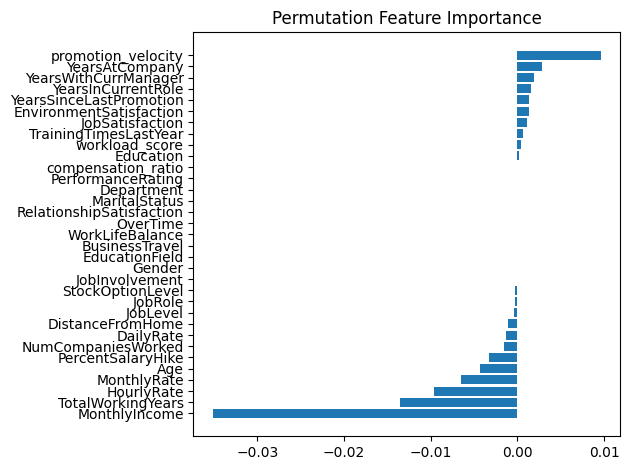

In [ ]:
result = permutation_importance(
    nb_classifier,
    X_test[X_train.columns],
    y_test,
    n_repeats=10,
    random_state=42
)

sorted_idx = result.importances_mean.argsort()

plt.barh(X_train.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()
plt.savefig('PFI - NB.jpg')
plt.close()

> Top featuers like promtion_velocity YearsAtCompany are the most effective featues in taking this decision.

> On the other hand feature like MonthlyIncome and TotalWorkingYears suggests that the model relies on them but incorrectly

> Feature like OverTime and WorkLifeBalance, has no impact (They are likely noise) at least that what this method tells us.